In [43]:
import os
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
data_df=pd.read_csv('mtsamples.csv')
print(data_df.head(10))
print(data_df.isnull().sum())
data_df.columns

   Unnamed: 0  ...                                           keywords
0           0  ...  allergy / immunology, allergic rhinitis, aller...
1           1  ...  bariatrics, laparoscopic gastric bypass, weigh...
2           2  ...  bariatrics, laparoscopic gastric bypass, heart...
3           3  ...  cardiovascular / pulmonary, 2-d m-mode, dopple...
4           4  ...  cardiovascular / pulmonary, 2-d, doppler, echo...
5           5  ...  bariatrics, gastric bypass, eea anastomosis, r...
6           6  ...  bariatrics, breast reconstruction, excess, lma...
7           7  ...  cardiovascular / pulmonary, 2-d echocardiogram...
8           8  ...  bariatrics, lipodystrophy, abd pads, suction-a...
9           9  ...  cardiovascular / pulmonary, ejection fraction,...

[10 rows x 6 columns]
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

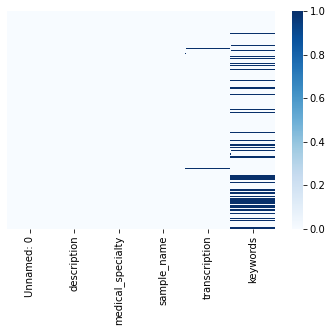

In [5]:
sns.heatmap(data=data_df.isnull(),yticklabels=False,cbar=True,cmap='Blues')

In [6]:
def sent_and_word_count(data):
    w_c=0
    s_c=0
    count={}
    for i in data:
        sentences= sent_tokenize(i)
        s_c=s_c+len(sentences)
        for sent in sentences:
            word_list=word_tokenize(sent)
            for word in word_list:
                if word in count.keys():
                    count[word]+=1
                else:
                    count[word]=1
    w_c=len(count.keys())
    return s_c,w_c
data_df=data_df[data_df['transcription'].notna()]
s_c,w_c=sent_and_word_count(data_df['transcription'].tolist())
print(s_c,w_c)

147007 41938


In [7]:
data_df['medical_specialty'].unique()

array([' Allergy / Immunology', ' Bariatrics',
       ' Cardiovascular / Pulmonary', ' Neurology', ' Dentistry',
       ' Urology', ' General Medicine', ' Surgery', ' Speech - Language',
       ' SOAP / Chart / Progress Notes', ' Sleep Medicine',
       ' Rheumatology', ' Radiology', ' Psychiatry / Psychology',
       ' Podiatry', ' Physical Medicine - Rehab',
       ' Pediatrics - Neonatal', ' Pain Management', ' Orthopedic',
       ' Ophthalmology', ' Office Notes', ' Obstetrics / Gynecology',
       ' Neurosurgery', ' Nephrology', ' Letters',
       ' Lab Medicine - Pathology', ' IME-QME-Work Comp etc.',
       ' Hospice - Palliative Care', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology', ' Endocrinology',
       ' Emergency Room Reports', ' Discharge Summary',
       ' Diets and Nutritions', ' Dermatology',
       ' Cosmetic / Plastic Surgery', ' Consult - History and Phy.',
       ' Chiropractic', ' Autopsy'], dtype=object)

In [8]:
#filtering the data that has more than 50 values
data_df=data_df.groupby(data_df['medical_specialty']).filter(lambda x:x.shape[0]>=50) 
for name,value in data_df.groupby(data_df['medical_specialty']):
    print(name+': '+str(len(value))) #checking whether all categories of filtered data has more than 50 values
print(value['transcription'].head(1))

 Cardiovascular / Pulmonary: 371
 Consult - History and Phy.: 516
 Discharge Summary: 108
 ENT - Otolaryngology: 96
 Emergency Room Reports: 75
 Gastroenterology: 224
 General Medicine: 259
 Hematology - Oncology: 90
 Nephrology: 81
 Neurology: 223
 Neurosurgery: 94
 Obstetrics / Gynecology: 155
 Office Notes: 50
 Ophthalmology: 83
 Orthopedic: 355
 Pain Management: 61
 Pediatrics - Neonatal: 70
 Psychiatry / Psychology: 53
 Radiology: 273
 SOAP / Chart / Progress Notes: 166
 Surgery: 1088
 Urology: 156
18    PROCEDURE: , Elective male sterilization via b...
Name: transcription, dtype: object


Unnamed: 0           4647
description          2304
medical_specialty      22
sample_name          2328
transcription        2325
keywords             3570
dtype: int64


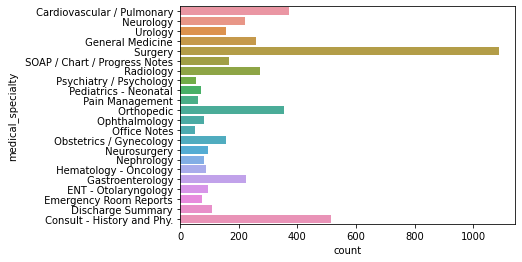

In [9]:
print(data_df.nunique())
sns.countplot(y='medical_specialty',data=data_df)
plt.show()

In [10]:
data=data_df[['transcription', 'medical_specialty']]
data=data[data['transcription'].notnull()]
print(data['transcription'].tolist()[1])
len(data['transcription'].tolist())


1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with mil

4647

In [11]:
import string
import regex as re
from nltk.stem import WordNetLemmatizer
def text_clean(text):
    text=text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
    text=''.join([i for i in text if not i.isdigit()]) #removing digits
    a=re.compile('[/(){}\[\]\|@,;]')
    final_text=text.lower()
    final_text=a.sub('',final_text)   #removing every special characters
    return final_text
def lemmatize(text):
    list_words=[]    #lemmatizing every sentence in the text
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for i in range(len(sentences)):
        words=word_tokenize(sentences[i])
        for word in words:
            list_words.append(lemmatizer.lemmatize(word))
    return ' '.join(list_words)
data['transcription']=data['transcription'].apply(lemmatize)
data['transcription']=data['transcription'].apply(text_clean)

In [12]:
data['transcription'].tolist()[0]

'd mmode     left atrial enlargement with left atrial diameter of  cm  normal size right and left ventricle  normal lv systolic function with left ventricular ejection fraction of     normal lv diastolic function  no pericardial effusion  normal morphology of aortic valve  mitral valve  tricuspid valve  and pulmonary valve  pa systolic pressure is  mmhg  doppler     mild mitral and tricuspid regurgitation  trace aortic and pulmonary regurgitation '

In [13]:
vectorizer= TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_df=0.85,analyzer='word',max_features=1000,)
id_matrix=vectorizer.fit_transform(data['transcription'].tolist())
sorted(vectorizer.get_feature_names())[1:10]

['abcd',
 'abdomen',
 'abdomen soft',
 'abdomen soft nontender',
 'abdomen wa',
 'abdominal',
 'abdominal pain',
 'able',
 'abnormal']

In [14]:
import gc
gc.collect()
tfID_dense=id_matrix.todense()

In [15]:
tsne=TSNE(n_components=2,random_state=0,perplexity=40).fit_transform(tfID_dense)

In [16]:
label=data['medical_specialty'].tolist()
tsne.shape

(4647, 2)

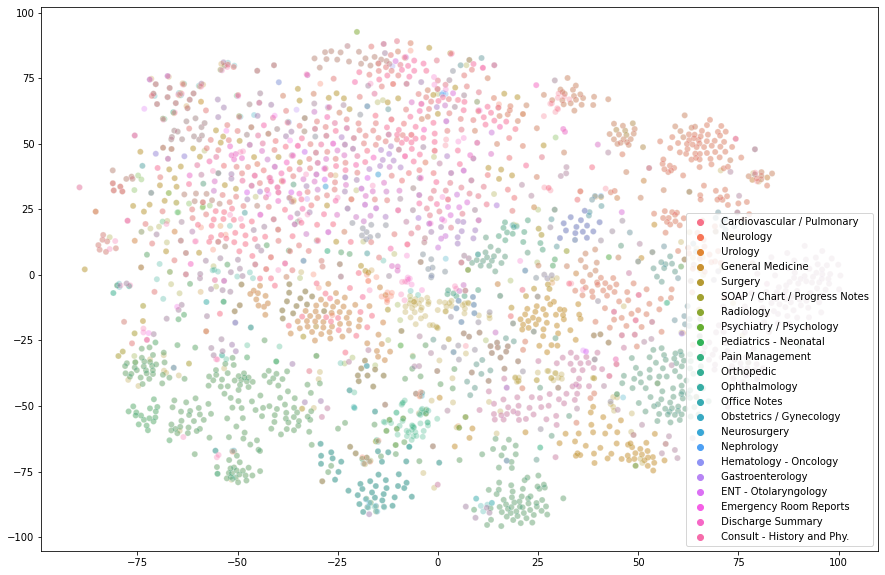

In [17]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=tsne[:,0],y=tsne[:,1],hue=label,alpha=0.3,legend='full')
plt.show()

In [30]:
#applying PCA
pca=PCA(n_components=0.95)
tfID_reduced=pca.fit_transform(id_matrix.toarray())
X_train, X_test, y_train, y_test=train_test_split(tfID_reduced,label,stratify=label,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3485, 595)
Test_Set_Size:(1162, 595)


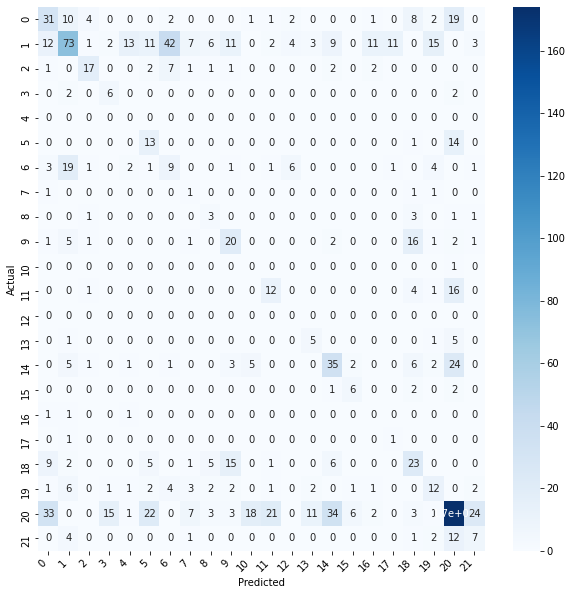

In [39]:
#applying logistic regression
classifier= LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5,random_state=1).fit(X_train,y_train)
pred=classifier.predict(X_test)
cm=confusion_matrix(pred,y_test)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
sns.heatmap(data=cm,cbar=True,cmap='Blues',annot=True)
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
plt.setp(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
plt.show()

In [44]:
#applying smote as there is way big difference in number of data
smote_data=SMOTE(sampling_strategy='minority')
label=data['medical_specialty'].tolist()
x,y=smote_data.fit_resample(tfIdfMat_reduced,label)
X_train, X_test, y_train, y_test=train_test_split(x,y,stratify=y,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(4263, 595)
Test_Set_Size:(1422, 595)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


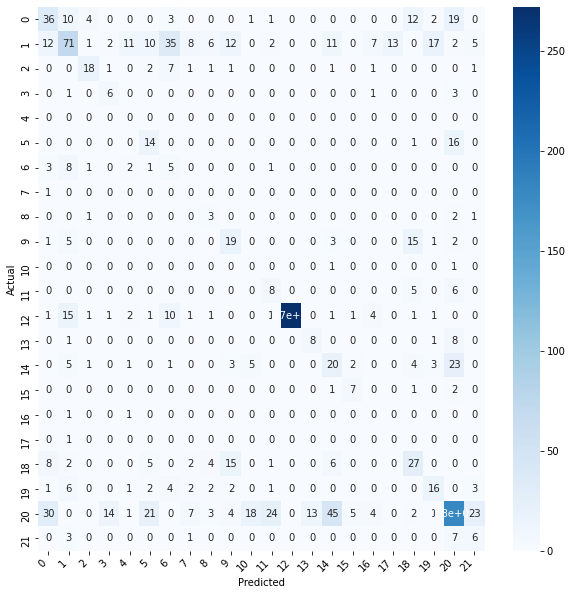

In [45]:
classifier= LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5,random_state=1).fit(X_train,y_train)
pred=classifier.predict(X_test)
cm=confusion_matrix(pred,y_test)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
sns.heatmap(data=cm,cbar=True,cmap='Blues',annot=True)
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
plt.setp(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
plt.show()

In [57]:
mask = data_df['medical_specialty'] == ' Cardiovascular / Pulmonary'
Cardiovascular_data = data_df[mask]
print(Cardiovascular_data['transcription'].tolist()[1]) #transcription data

1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with mil

The data seems to be very noisy even when data balancing was performed. Accuracy can be increased by specifying precise medical speciality. For ex: the data of neurosurgery is a part of neurology, hence the data for neurosurgery and neurology is relatively less than that of general medicine.
